In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from UCI machine learning repository. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `Global active power` which has data from December 2006 and November 2010 (47 months).

In [0]:
data = pd.read_csv('/content/output.csv', index_col=[0], parse_dates=[0])

FileNotFoundError: ignored

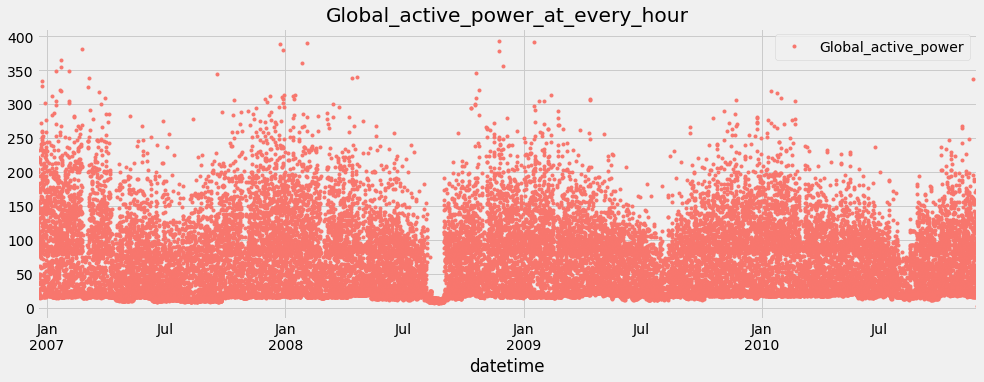

In [0]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='.', figsize=(15,5), color=color_pal[0], title='Global_active_power_at_every_hour')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [0]:
split_date = '26-nov-2009'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

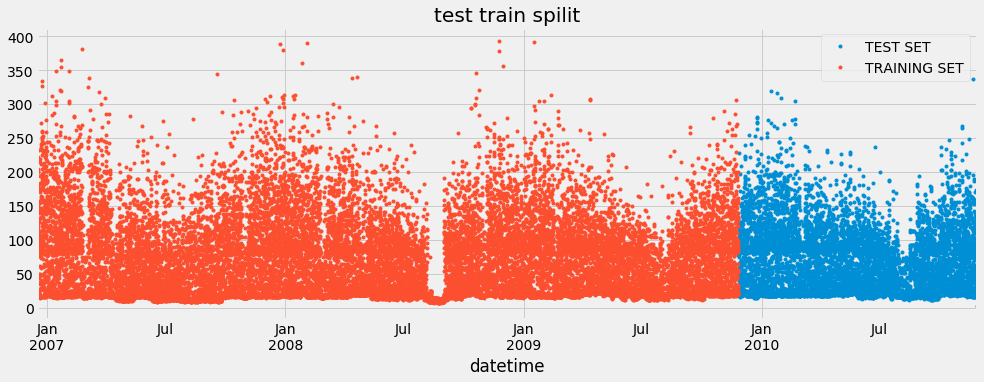

In [0]:
_ = data_test \
    .rename(columns={'Global_active_power': 'TEST SET'}) \
    .join(data_train.rename(columns={'Global_active_power': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='test train spilit', style='.')

# Create Time Series Features

In [0]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
X_train, y_train = create_features(data_train, label='Global_active_power')
X_test, y_test = create_features(data_test, label='Global_active_power')

# Create XGBoost Model

In [0]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

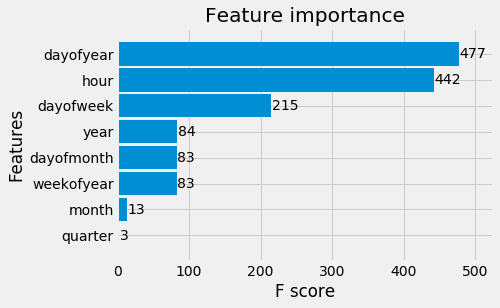

In [0]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [0]:
data_test['KW_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

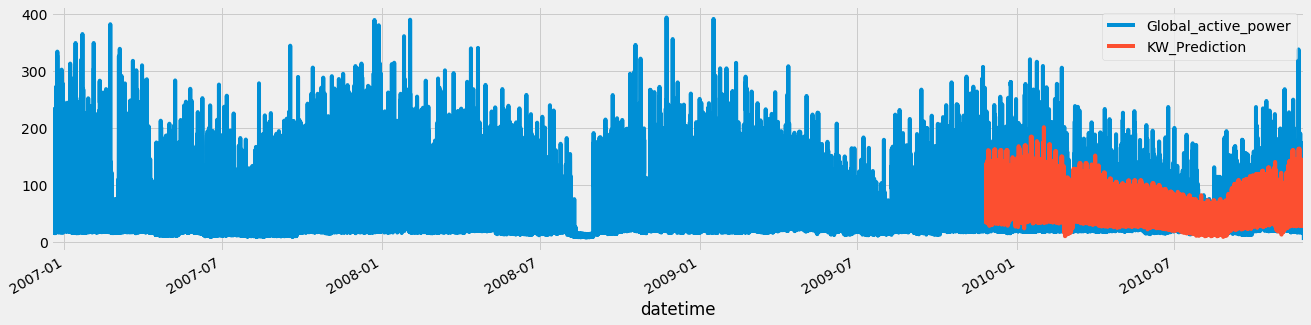

In [0]:
_ = data_all[['Global_active_power','KW_Prediction']].plot(figsize=(20, 5))

# Look at first month of predictions (winters)

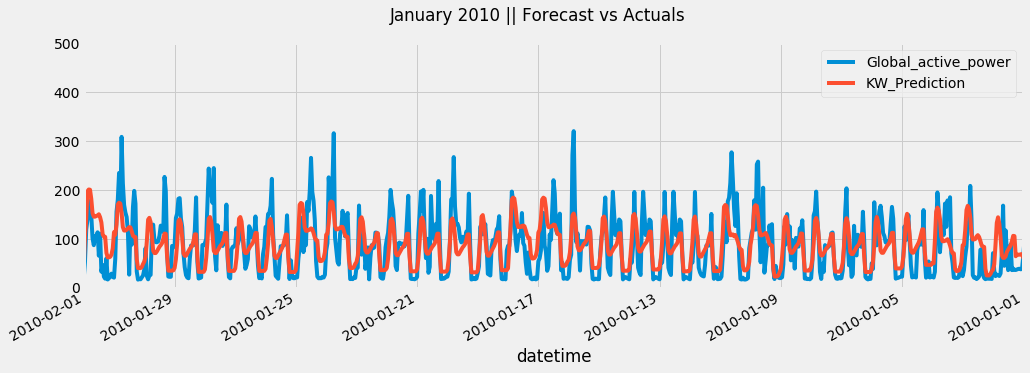

In [0]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-jan-2010', upper='01-feb-2010')
ax.set_ylim(0, 500)
plot = plt.suptitle('January 2010 || Forecast vs Actuals')

# Look at first week of predictions

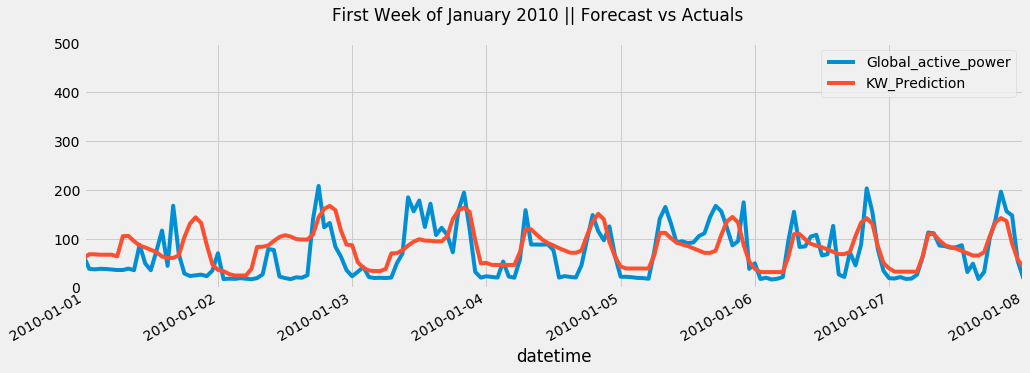

In [0]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-jan-2010', upper='08-jan-2010')
ax.set_ylim(0, 500)
plot = plt.suptitle('First Week of January 2010 || Forecast vs Actuals')

# predictions of month (summer)

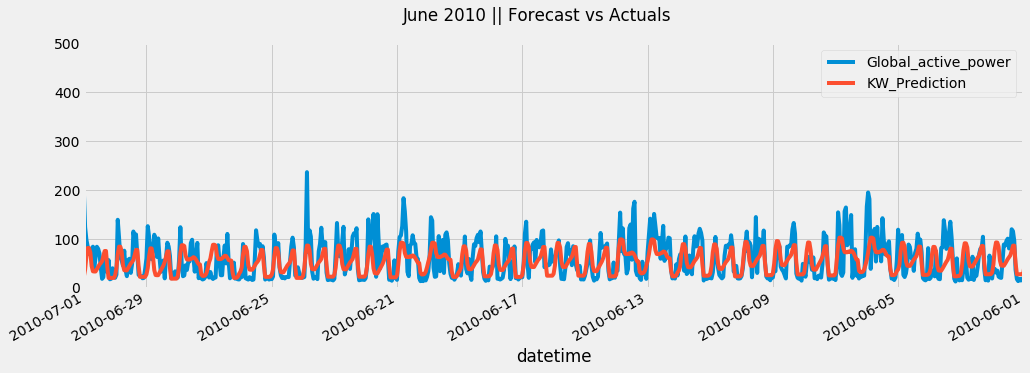

In [0]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-jun-2010', upper='01-jul-2010')
ax.set_ylim(0, 500)
plot = plt.suptitle('June 2010 || Forecast vs Actuals')

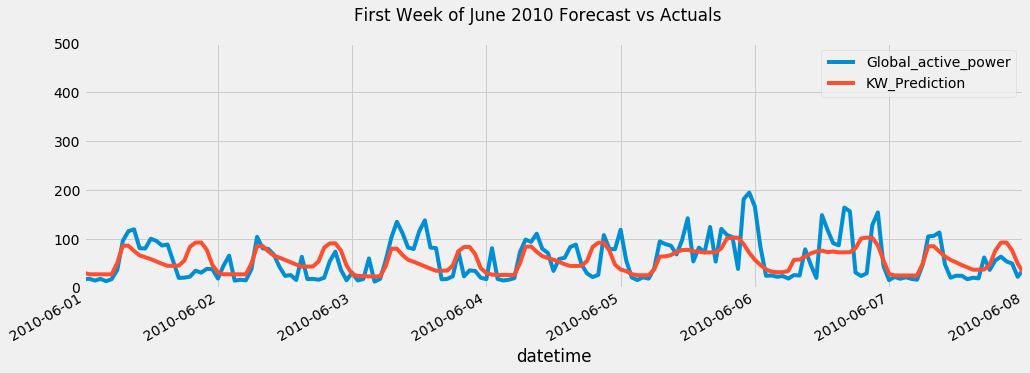

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(0, 500)
ax.set_xbound(lower='01-jun-2010', upper='08-jun-2010')
plot = plt.suptitle('First Week of June 2010 Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 1404.5  
Our MAE error is 28  
Our MAPE error is 64%

In [0]:
mean_squared_error(y_true=data_test['Global_active_power'],y_pred=data_test['KW_Prediction'])

1404.4662848073554

In [0]:
mean_absolute_error(y_true=data_test['Global_active_power'],y_pred=data_test['KW_Prediction'])

27.93879861043659

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
mean_absolute_percentage_error(y_true=data_test['Global_active_power'],y_pred=data_test['KW_Prediction'])

64.28346073863818

# Look at Worst and Best Predicted Days

In [0]:
data_test['error'] = data_test['Global_active_power'] - data_test['KW_Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Global_active_power','KW_Prediction','error','abs_error']]

In [0]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Global_active_power  KW_Prediction      error  abs_error
year month dayofmonth                                                          
2010 11    21                    37.537917      95.369766 -57.831846  61.773586
2009 12    20                    47.673583      99.897064 -52.223482  61.184071
2010 1     31                    74.966500     126.458725 -51.492227  51.492227
     3     6                     33.113000      74.691971 -41.578968  41.578968
     2     7                     67.737833     106.049538 -38.311701  40.026514
     10    16                    41.667250      79.138748 -37.471497  46.175664
           17                    43.640917      79.249489 -35.608574  39.236271
     1     17                    79.439833     114.373314 -34.933480  38.711161
           2                     54.552833      88.713364 -34.160530  44.906723
     2     28                    29.652750      61.958664 -32.305913  39.776864

Notice anything about the over forecasted days? 
- #1 worst day - november 21st, 2010 - is a sunday. 
- #2 worst day - December 20th, 2009 - is a sunday
- #3 worst day - January  31st, 2010 - is also a sunday.   
Looks like our model may benefit from adding a sunday indicator.

In [0]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Global_active_power  KW_Prediction      error  abs_error
year month dayofmonth                                                          
2009 12    24                   121.078917      77.900383  43.178533  74.874747
2010 11    21                    37.537917      95.369766 -57.831846  61.773586
2009 12    20                    47.673583      99.897064 -52.223482  61.184071
2010 10    31                    61.517917      67.335159  -5.817240  59.339565
           18                   113.078500      64.619225  48.459274  57.184402
     11    4                    106.464417      53.992546  52.471870  55.054633
     8     27                    84.610417      33.285099  51.325318  54.443755
     1     24                    94.559167     107.140099 -12.580932  54.070282
2009 12    19                    91.847250      99.551468  -7.704216  52.796617
2010 4     25                    64.280917      67.033546  -2.752627  52.728327

The best predicted days seem to be a lot of july and august (not many holidays and mild weather)

In [0]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Global_active_power  KW_Prediction     error  abs_error
year month dayofmonth                                                         
2010 7     6                     41.913917      47.576523 -5.662606  12.651268
     6     24                    45.657500      45.425045  0.232456  13.314005
     11    7                     69.742333      73.742401 -4.000066  13.528446
     7     29                    22.879333      31.115936 -8.236602  14.445619
     8     24                    30.122833      34.883217 -4.760384  15.057331
     9     24                    55.333000      58.887142 -3.554142  15.232957
           9                     51.613083      48.496861  3.116222  15.326745
     8     26                    31.552167      29.304169  2.247997  15.375231
     9     27                    56.270250      56.270451 -0.000199  15.497120
     8     23                    31.902417      32.723225 -0.820806  15.640711

# Plotting some best/worst predicted days

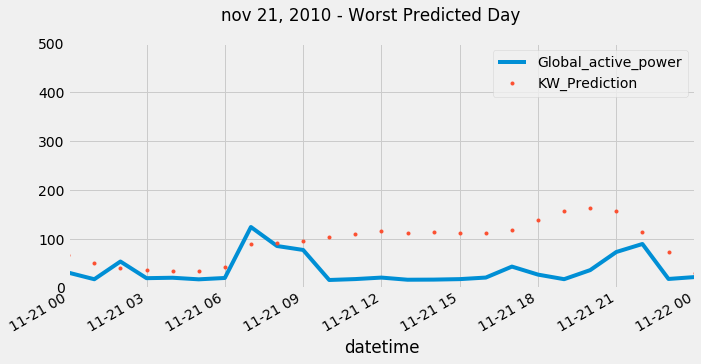

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 500)
ax.set_xbound(lower='21-nov-2010', upper='22-nov-2010')
plot = plt.suptitle('nov 21, 2010 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

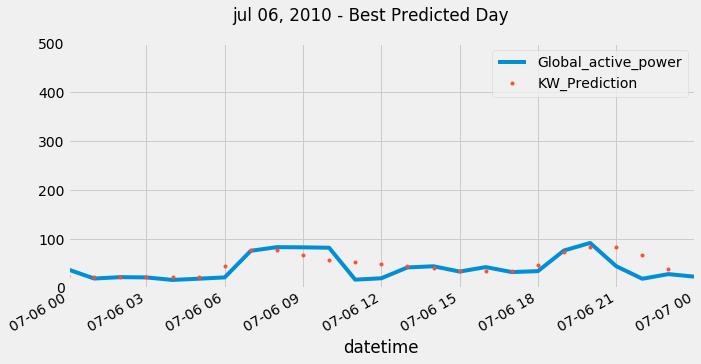

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['Global_active_power','KW_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 500)
ax.set_xbound(lower='06-jul-2010', upper='07-jul-2010')
plot = plt.suptitle('jul 06, 2010 - Best Predicted Day')